In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from metric import visualize_epoch_results
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from src.inference import inference, inference2pos

sample_submission = pd.read_csv("../../inputs/sample_submission.csv")

In [2]:
# padf = PadToSize(CFG.resolution)


# def last_padding(tomogram, slice_size):
#     # tomogram: (tensor)
#     b, d, h, w = tomogram.shape
#     last_padding = slice_size - d % slice_size
#     if last_padding == slice_size:
#         return tomogram
#     else:
#         return torch.cat(
#             [tomogram, torch.zeros(b, last_padding, h, w).to(tomogram.device)], dim=1
#         )


# def preprocess_tensor(tensor):
#     batch_size, depth, height, width = tensor.shape
#     tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
#     return tensor


# def inference(model, exp_name, train=True):
#     dataset = EziiDataset(
#         exp_names=[exp_name],
#         base_dir="../../inputs/train/",
#         particles_name=CFG.particles_name,
#         resolution=CFG.resolution,
#         zarr_type=["denoised"],
#         train=train,
#         slice=False,
#     )
#     res_array = CFG.original_img_shape[CFG.resolution]
#     pred_array = np.zeros(
#         (len(CFG.particles_name) + 1, res_array[0], res_array[1], res_array[2])
#     )
#     loader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)
#     model.eval()
#     # tq = tqdm(loader)
#     for data in loader:  # 実験データ1つを取り出す
#         for i in range(0, data["normalized_tomogram"].shape[1], CFG.slice_):
#             normalized_tomogram = data["normalized_tomogram"][:, i : i + CFG.slice_]
#             normalized_tomogram = last_padding(normalized_tomogram, CFG.slice_)
#             normalized_tomogram = padf(normalized_tomogram)
#             normalized_tomogram = preprocess_tensor(normalized_tomogram).to("cuda")
#             pred = model(normalized_tomogram)
#             prob_pred = (
#                 torch.softmax(pred, dim=1).detach().cpu().numpy()
#             )  # torch.Size([1, 7, 32, 320, 320])
#             range_ = min(i + CFG.slice_, res_array[0])
#             hw_pad_diff = prob_pred.shape[-1] - res_array[-1]

#             if i >= res_array[0]:
#                 continue

#             if range_ == res_array[0]:
#                 pred_array[:, i:range_] += prob_pred[
#                     0, :, : res_array[0] - i, :-hw_pad_diff, :-hw_pad_diff
#                 ]
#             else:
#                 pred_array[:, i:range_] += prob_pred[
#                     0, :, :range_, :-hw_pad_diff, :-hw_pad_diff
#                 ]

#         if train:
#             segmentation_map = data["segmentation_map"]
#         else:
#             segmentation_map = None

#         normalized_tomogram = data["normalized_tomogram"]
#     # tq.close()

#     return pred_array, normalized_tomogram, segmentation_map  # (7, 92, 315, 315)


# def inference2pos(pred_segmask, exp_name):
#     import cc3d

#     cls_pos = []
#     Ascale_pos = []
#     res2ratio = CFG.resolution2ratio

#     for pred_cls in range(1, len(CFG.particles_name) + 1):
#         print(pred_cls, CFG.cls2particles[pred_cls])
#         cc, P = cc3d.connected_components(pred_segmask == pred_cls, return_N=True)
#         stats = cc3d.statistics(cc)

#         for z, y, x in stats["centroids"]:
#             Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

#             cls_pos.append([pred_cls, z, y, x])
#             Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

#     pred_original_df = create_df(Ascale_pos, exp_name)

#     return pred_original_df

In [3]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
model.load_state_dict(torch.load("./best_model.pth"))

<All keys matched successfully>

In [4]:
from tqdm import tqdm

# ############### validation ################
train_nshuffle_original_tomogram = defaultdict(list)
train_nshuffle_pred_tomogram = defaultdict(list)
train_nshuffle_gt_tomogram = defaultdict(list)
train_cls_pos = defaultdict(list)
train_cls_Apos = defaultdict(list)

valid_original_tomogram = defaultdict(list)
valid_pred_tomogram = defaultdict(list)
valid_gt_tomogram = defaultdict(list)
valid_cls_pos = defaultdict(list)
valid_cls_Apos = defaultdict(list)

train_mean_scores = []
valid_mean_scores = []

# for exp_name in tqdm(CFG.train_exp_names):
for exp_name in tqdm(CFG.train_exp_names[:5]):  # 5つのデータで試す
    inferenced_array, n_tomogram, segmentation_map = inference(
        model, exp_name, train=True
    )
    train_nshuffle_pred_tomogram[exp_name] = inferenced_array
    train_nshuffle_gt_tomogram[exp_name] = segmentation_map.squeeze(0)
    train_nshuffle_original_tomogram[exp_name] = n_tomogram.squeeze(0)

    mean_score, scores, pred_df, gt_df, pred_cls_pos, pred_Ascale_pos = (
        visualize_epoch_results(
            train_nshuffle_pred_tomogram,
            base_dir="../../inputs/train/overlay/ExperimentRuns/",
            sikii_dict=CFG.initial_sikii,
        )
    )
    train_cls_pos[exp_name] = pred_cls_pos
    train_cls_Apos[exp_name] = pred_Ascale_pos
    train_mean_scores.append(mean_score)
print("train_mean_scores", np.mean(train_mean_scores))

for exp_name in tqdm(CFG.valid_exp_names):
    inferenced_array, n_tomogram, segmentation_map = inference(
        model, exp_name, train=True
    )
    valid_pred_tomogram[exp_name] = inferenced_array
    valid_gt_tomogram[exp_name] = segmentation_map.squeeze(0)
    valid_original_tomogram[exp_name] = n_tomogram.squeeze(0)

    mean_score, scores, pred_df, gt_df, pred_cls_pos, pred_Ascale_pos = (
        visualize_epoch_results(
            valid_pred_tomogram,
            base_dir="../../inputs/train/overlay/ExperimentRuns/",
            sikii_dict=CFG.initial_sikii,
        )
    )
    valid_cls_pos[exp_name] = pred_cls_pos
    valid_cls_Apos[exp_name] = pred_Ascale_pos
    valid_mean_scores.append(mean_score)
print("valid_mean_scores", np.mean(valid_mean_scores))

100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


train_mean_scores 0.04018693972621258


100%|██████████| 2/2 [00:05<00:00,  2.98s/it]

valid_mean_scores 0.0


In [5]:
inferenced_array, n_tomogram, segmentation_map = inference(model, exp_name, train=True)
pred_original_df = inference2pos(
    pred_segmask=inferenced_array.argmax(1), exp_name=exp_name
)
pred_df

index experiment       particle_type       x       y          z
0      0     TS_6_6        apo-ferritin  3140.0  3140.0  69.999832
1      1     TS_6_6        apo-ferritin  3140.0  3140.0   0.001008
2      2     TS_6_6        beta-amylase  3140.0  3140.0  69.999496
3      3     TS_6_6        beta-amylase  3140.0  3140.0   0.003023
4      4     TS_6_6  beta-galactosidase  3140.0  3140.0  69.999429
5      5     TS_6_6  beta-galactosidase  3140.0  3140.0   0.003427
6      6     TS_6_6            ribosome  3140.0  3140.0  69.999563
7      7     TS_6_6            ribosome  3140.0  3140.0   0.002620
8      8     TS_6_6       thyroglobulin  3140.0  3140.0  70.000000
9      9     TS_6_6       thyroglobulin  3140.0  3140.0   0.000000

In [6]:
score(pred_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4)

0.0

In [7]:
pred_df[pred_df["particle_type"] == "apo-ferritin"].sort_values("z")

index experiment particle_type       x       y          z
1      1     TS_6_6  apo-ferritin  3140.0  3140.0   0.001008
0      0     TS_6_6  apo-ferritin  3140.0  3140.0  69.999832

In [8]:
gt_df[gt_df["particle_type"] == "apo-ferritin"].sort_values("z")

index experiment particle_type         x         y         z
17     17     TS_6_6  apo-ferritin  5344.971   446.000    60.429
23     23     TS_6_6  apo-ferritin  3101.770  1278.918   264.197
16     16     TS_6_6  apo-ferritin  4905.120  1090.843   266.175
19     19     TS_6_6  apo-ferritin  5066.127  1954.349   293.048
26     26     TS_6_6  apo-ferritin  4212.422  2013.806   305.882
3       3     TS_6_6  apo-ferritin   285.292  1379.331   417.577
21     21     TS_6_6  apo-ferritin  5794.353  2457.302   441.691
29     29     TS_6_6  apo-ferritin  2977.845  4634.696   444.254
28     28     TS_6_6  apo-ferritin  3153.077  4790.538   460.577
32     32     TS_6_6  apo-ferritin   318.185  5000.579   551.158
27     27     TS_6_6  apo-ferritin  4057.610  5767.868   576.581
12     12     TS_6_6  apo-ferritin   818.107  3625.562   671.657
13     13     TS_6_6  apo-ferritin  1146.957  1508.462   679.398
30     30     TS_6_6  apo-ferritin  3332.697  5251.364   720.576
7       7     TS_6_6  apo-ferritin  1123.151  2698.296   725.852
0       0     TS_6_6  apo-ferritin  1916.830  3311.797   754.673
14     14     TS_6_6  apo-ferritin  4586.585   476.585   763.780
15     15     TS_6_6  apo-ferritin  4528.663   551.489   773.374
20     20     TS_6_6  apo-ferritin  5671.396  2753.784   797.838
1       1     TS_6_6  apo-ferritin  1996.861  3231.277   803.577
36     36     TS_6_6  apo-ferritin  3432.444  1208.430   826.027
18     18     TS_6_6  apo-ferritin  5250.109  3132.920   842.628
37     37     TS_6_6  apo-ferritin  3074.149  1859.506   846.052
8       8     TS_6_6  apo-ferritin  1234.692  2994.751   920.469
35     35     TS_6_6  apo-ferritin  5680.786  2759.578   936.164
25     25     TS_6_6  apo-ferritin  3109.837  1800.782   954.072
4       4     TS_6_6  apo-ferritin   753.781  2633.219   973.094
33     33     TS_6_6  apo-ferritin  1776.173  4887.716  1019.877
31     31     TS_6_6  apo-ferritin  3442.903  5827.204  1080.502
22     22     TS_6_6  apo-ferritin  3355.743  2365.446  1138.614
38     38     TS_6_6  apo-ferritin  1949.780  3068.740  1156.437
2       2     TS_6_6  apo-ferritin  2206.512  2975.302  1179.674
34     34     TS_6_6  apo-ferritin  3578.705  3480.026  1206.500
9       9     TS_6_6  apo-ferritin   332.707  3382.279  1241.909
39     39     TS_6_6  apo-ferritin  3687.965  1751.484  1296.612
11     11     TS_6_6  apo-ferritin  1569.207  2394.552  1299.690
40     40     TS_6_6  apo-ferritin  3684.710  1654.009  1306.624
24     24     TS_6_6  apo-ferritin  2705.768  1889.625  1354.642
5       5     TS_6_6  apo-ferritin   726.176  2559.490  1473.314
10     10     TS_6_6  apo-ferritin   766.772  3170.667  1543.544
6       6     TS_6_6  apo-ferritin   747.829  2630.698  1549.302

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im


def imshow_result(pred, gt, original, index):
    # plt.figure(figsize=(20, 5))
    ax = plt.subplot(1, 3, 1)
    plot_with_colormap(
        pred[index],
        "Train-Prediction",
        original[index],
    )
    ax = plt.subplot(1, 3, 2)
    plot_with_colormap(gt[index], "Gt", original[index])

    ax = plt.subplot(1, 3, 3)
    plt.imshow(original[index], cmap="gray")
    plt.axis("off")

    plt.show()

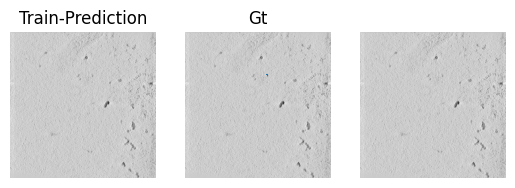

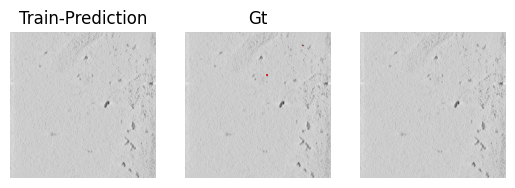

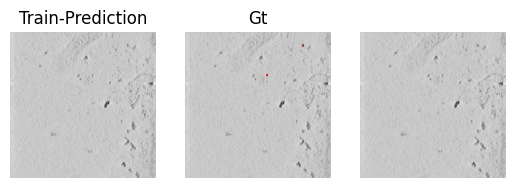

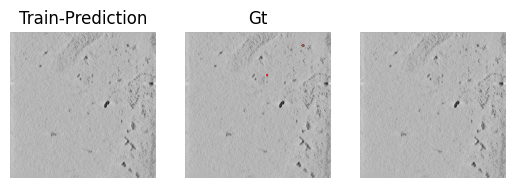

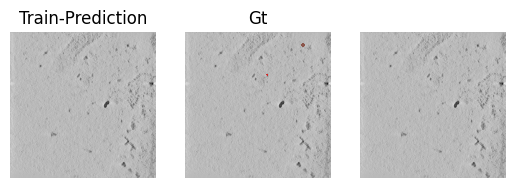

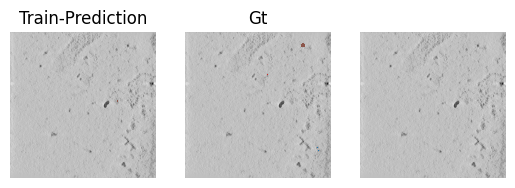

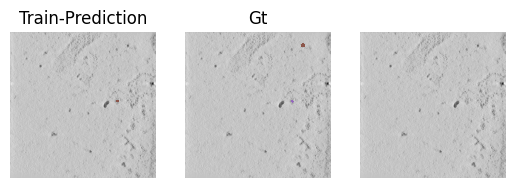

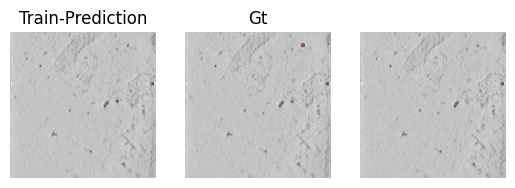

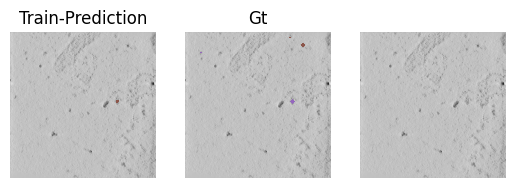

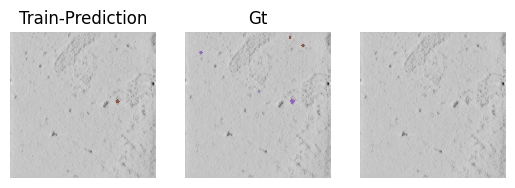

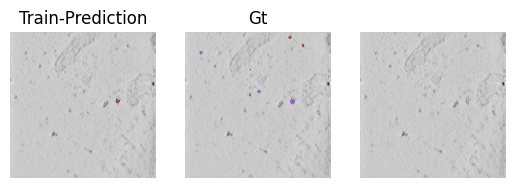

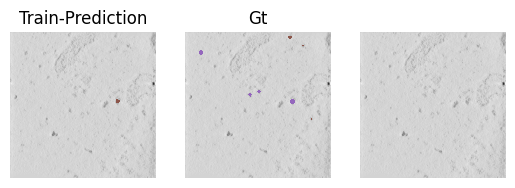

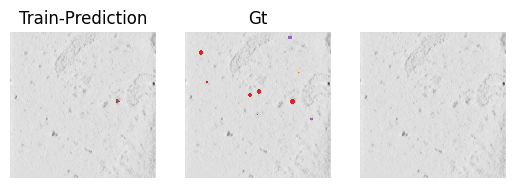

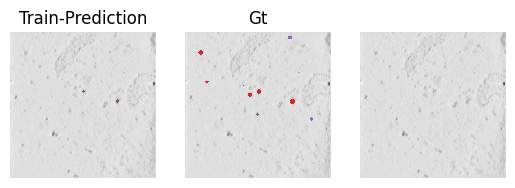

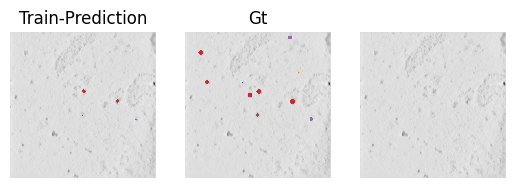

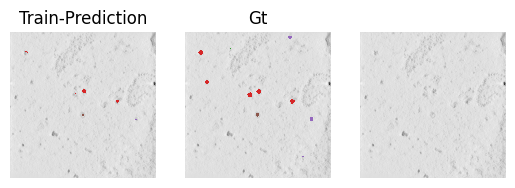

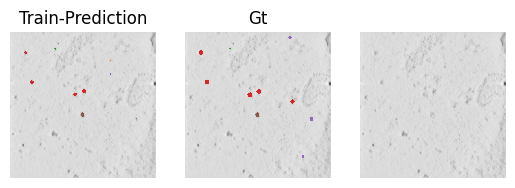

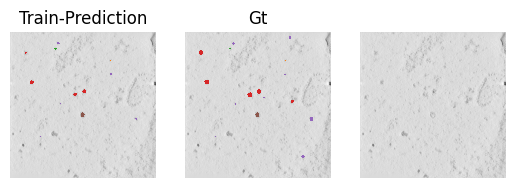

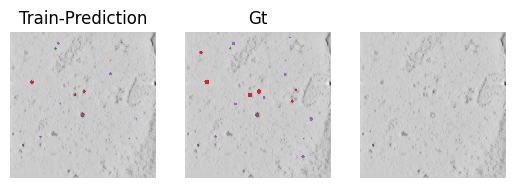

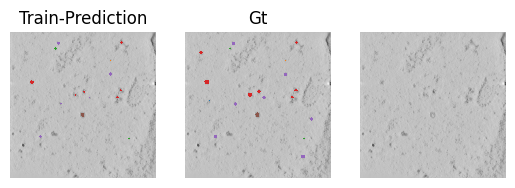

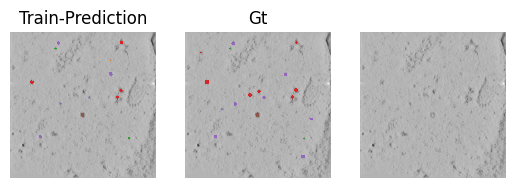

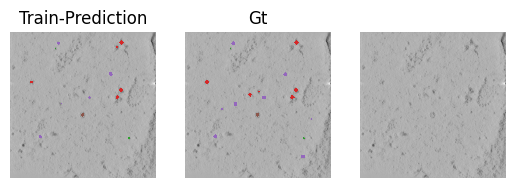

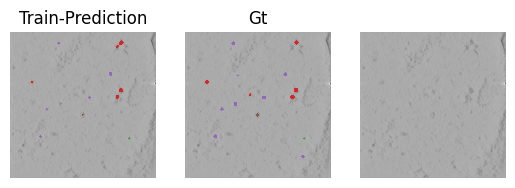

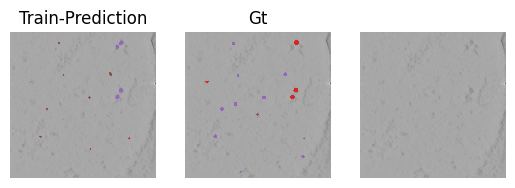

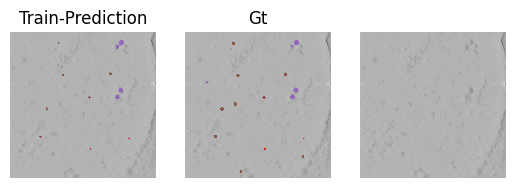

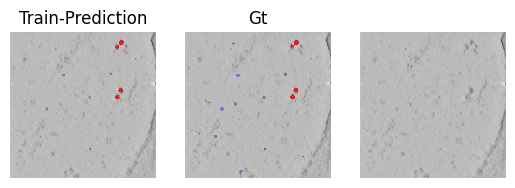

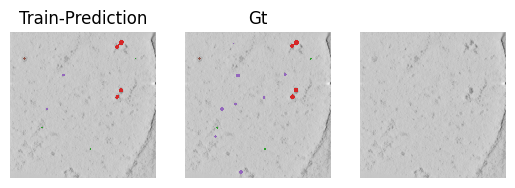

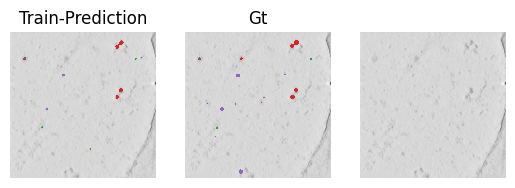

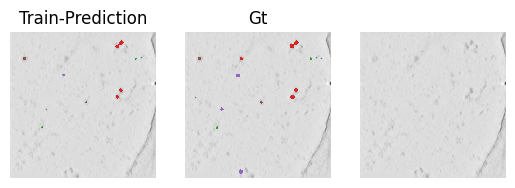

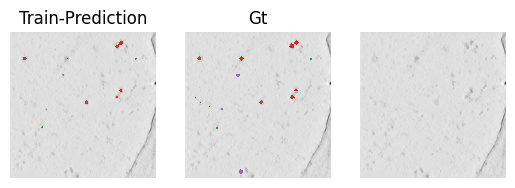

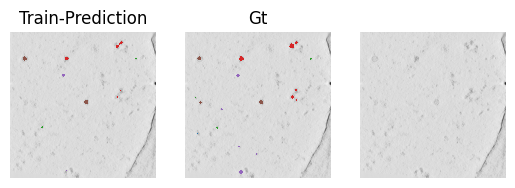

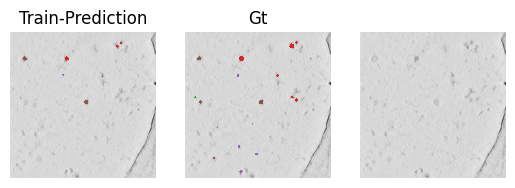

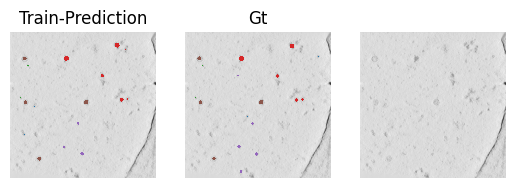

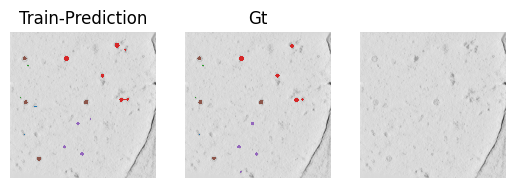

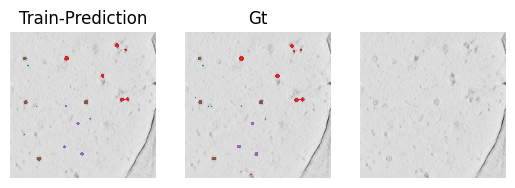

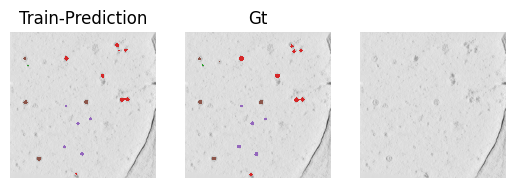

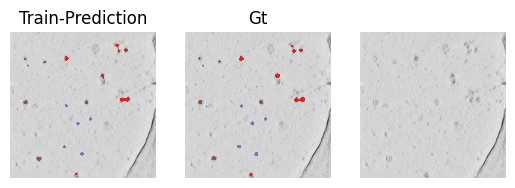

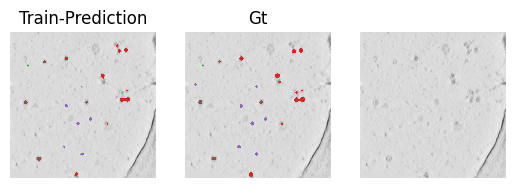

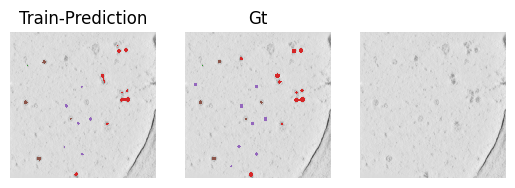

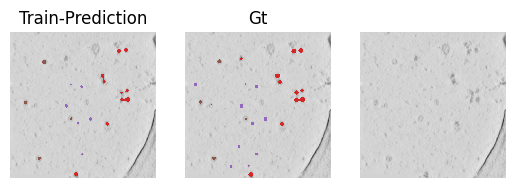

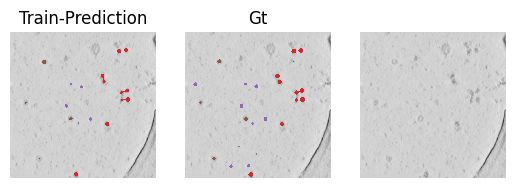

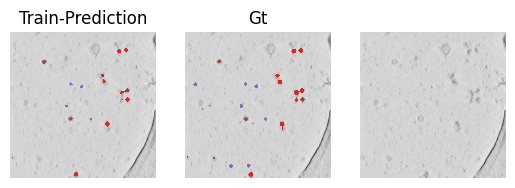

In [10]:
exp_name = "TS_5_4"
index = 12
pred = train_nshuffle_pred_tomogram[exp_name].argmax(0)  # (92, 315, 315)
gt = train_nshuffle_gt_tomogram[exp_name]
original = train_nshuffle_original_tomogram[exp_name]

# imshow_result(pred, gt, original, index)

for i in range(42):
    imshow_result(pred, gt, original, i)

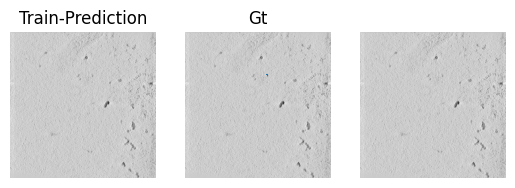

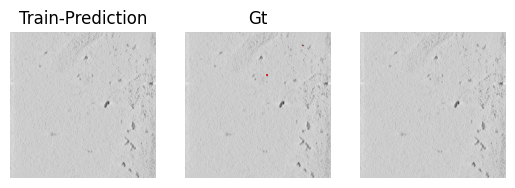

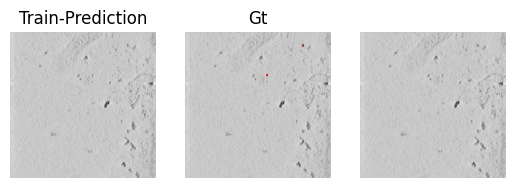

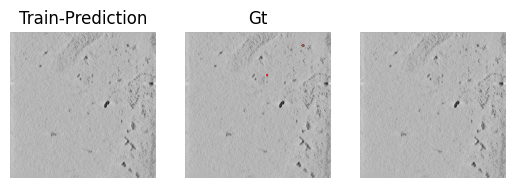

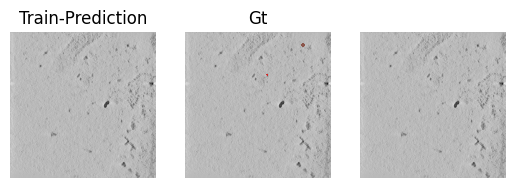

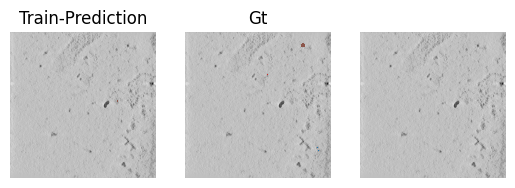

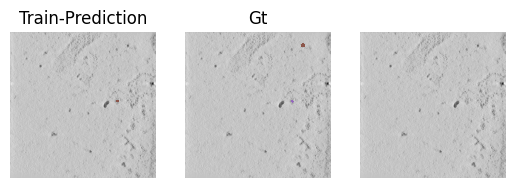

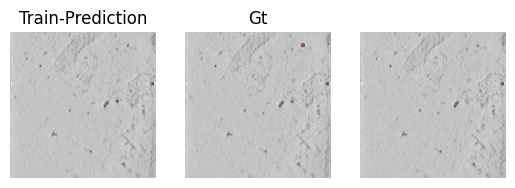

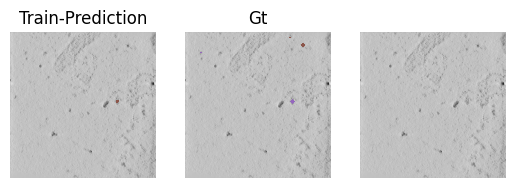

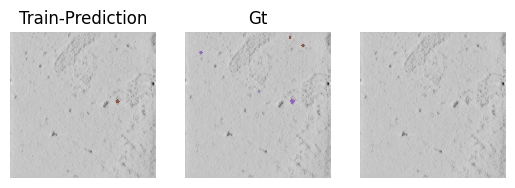

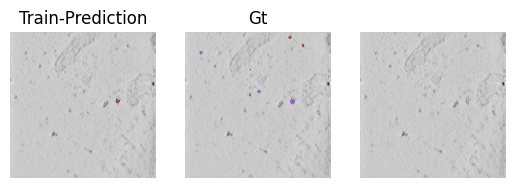

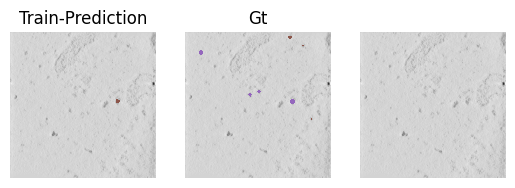

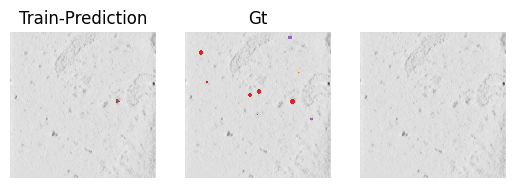

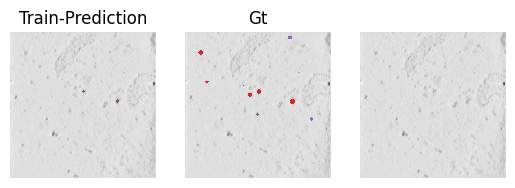

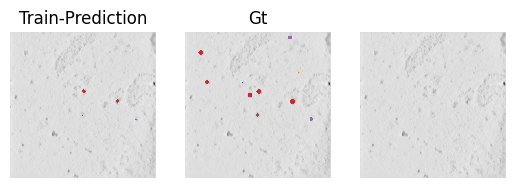

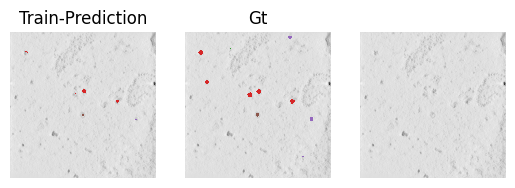

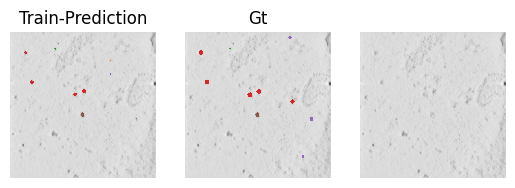

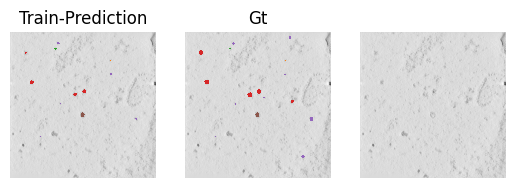

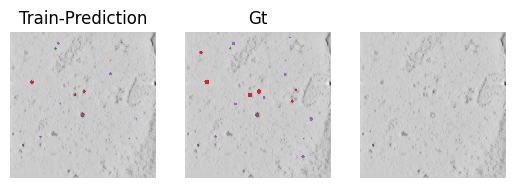

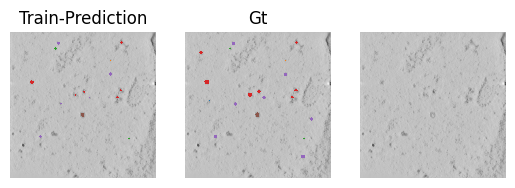

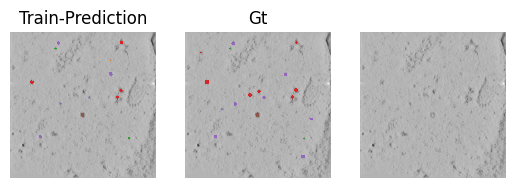

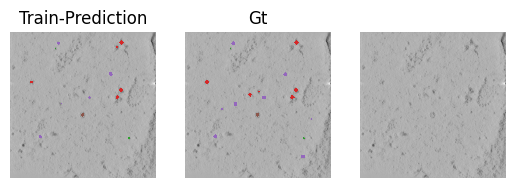

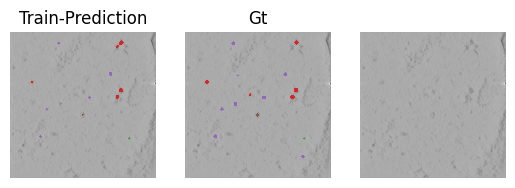

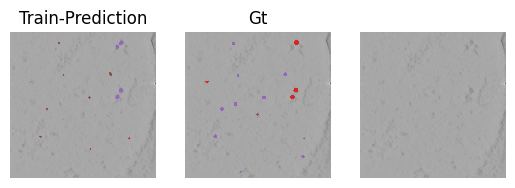

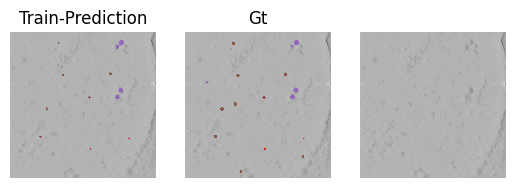

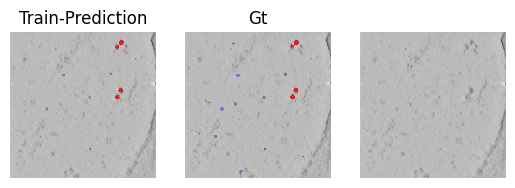

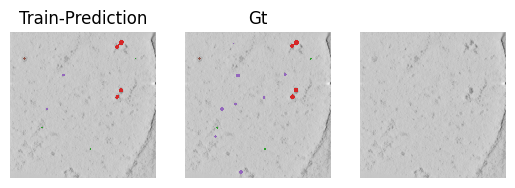

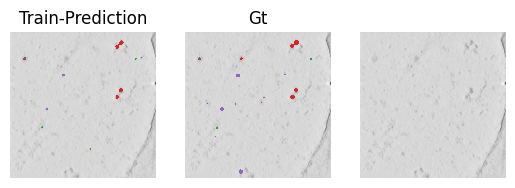

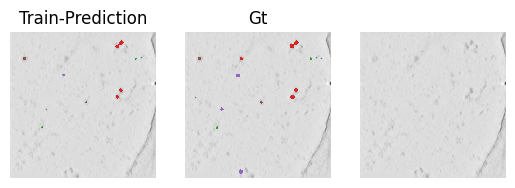

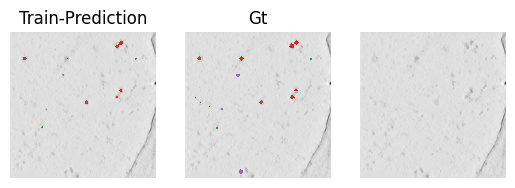

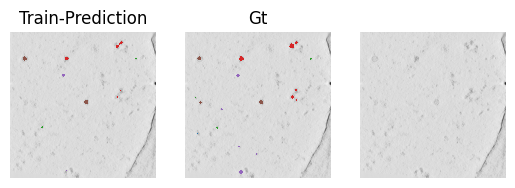

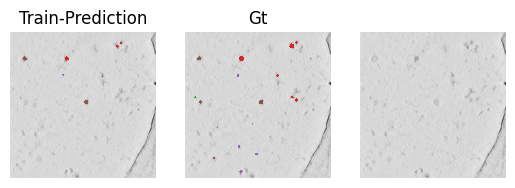

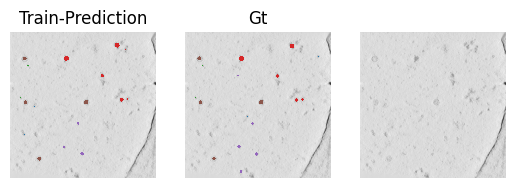

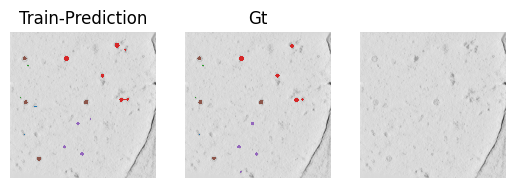

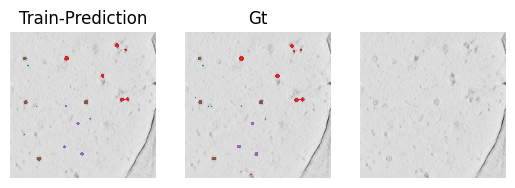

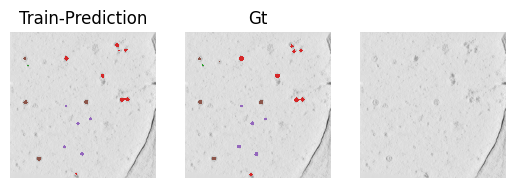

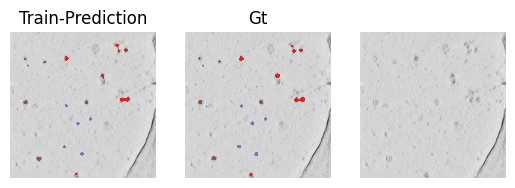

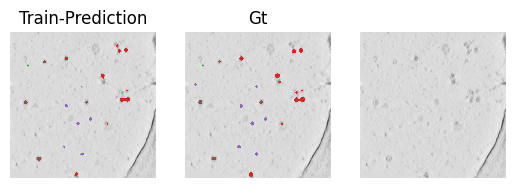

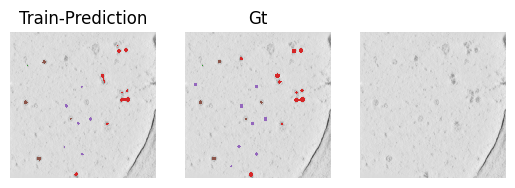

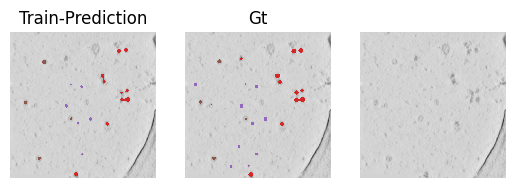

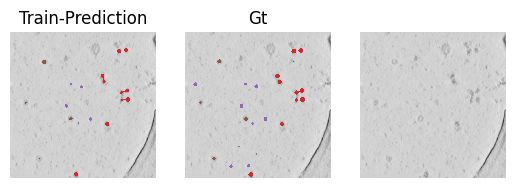

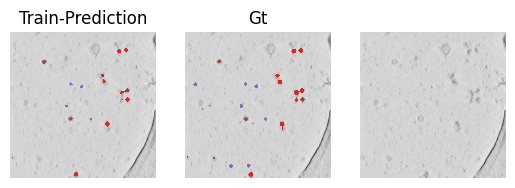

In [11]:
exp_name = "TS_5_4"
index = 12
pred = train_nshuffle_pred_tomogram[exp_name].argmax(0)  # (92, 315, 315)
gt = train_nshuffle_gt_tomogram[exp_name]
original = train_nshuffle_original_tomogram[exp_name]

# imshow_result(pred, gt, original, index)

for i in range(42):
    imshow_result(pred, gt, original, i)

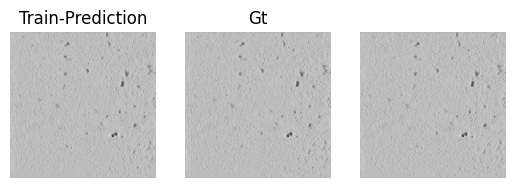

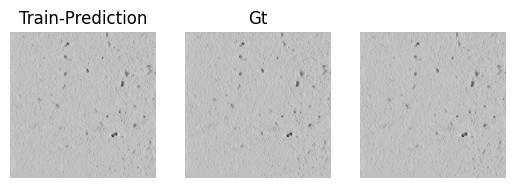

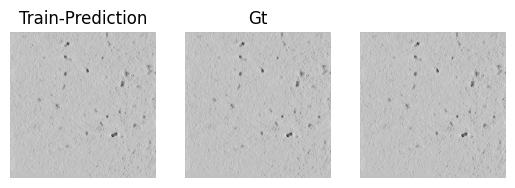

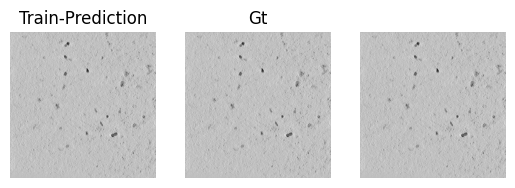

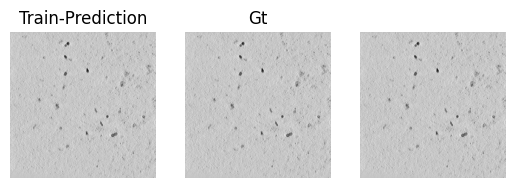

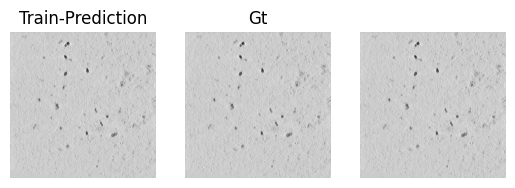

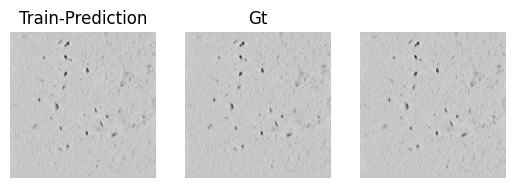

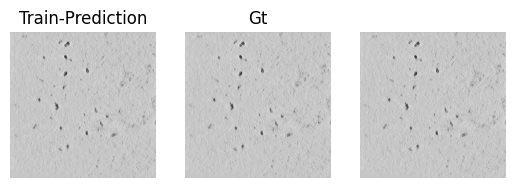

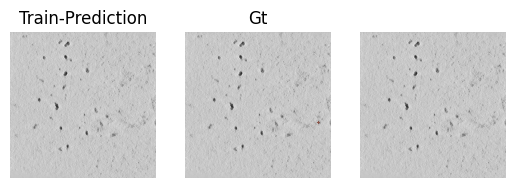

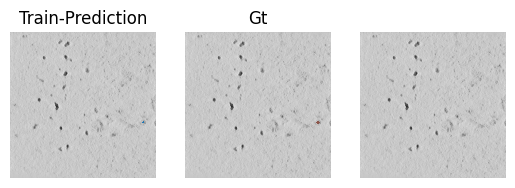

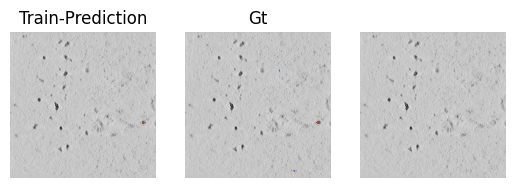

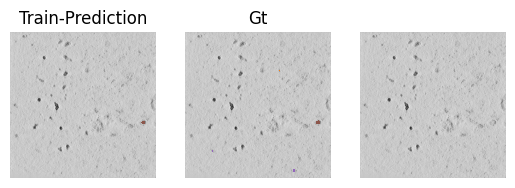

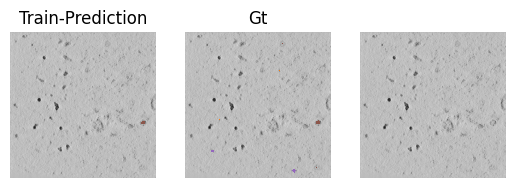

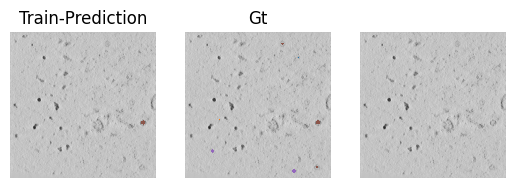

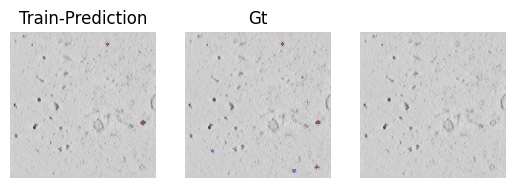

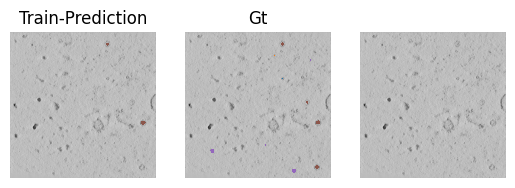

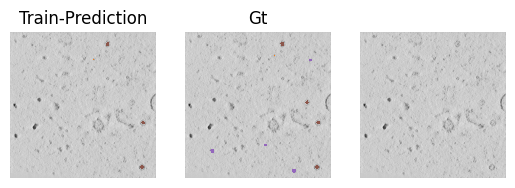

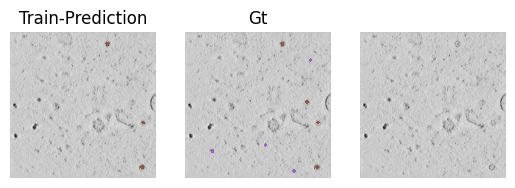

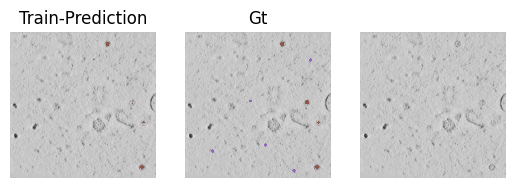

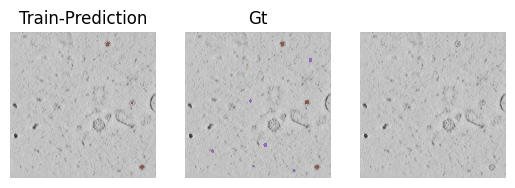

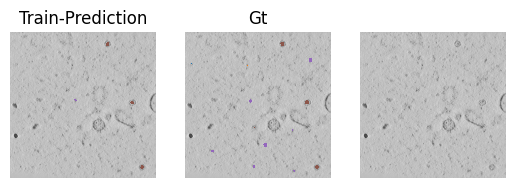

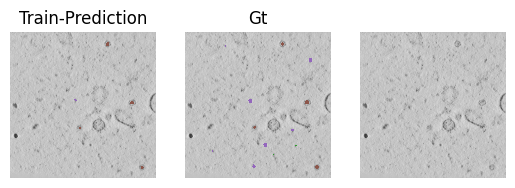

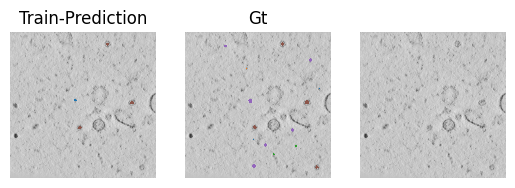

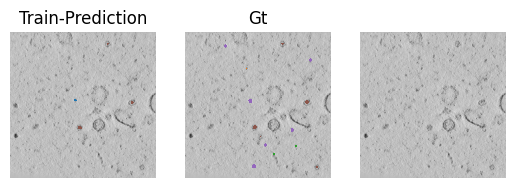

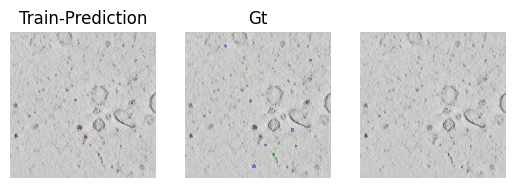

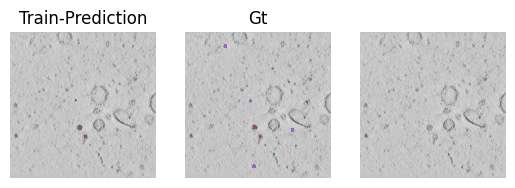

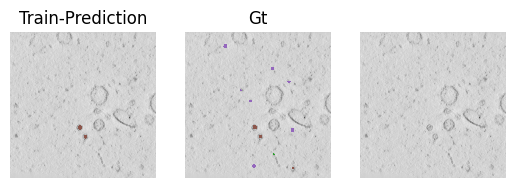

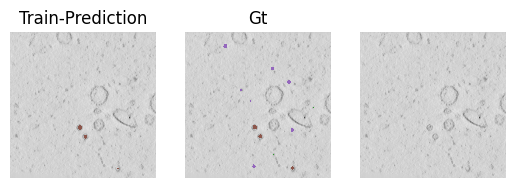

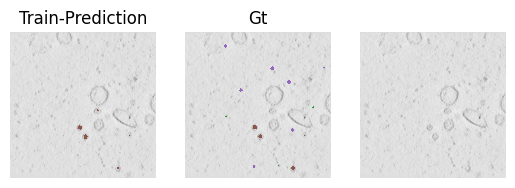

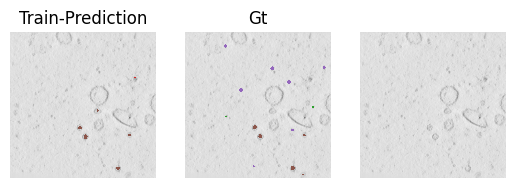

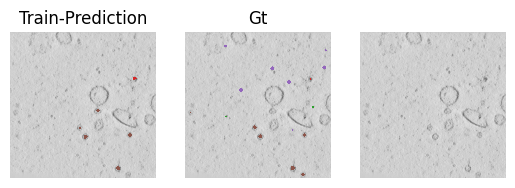

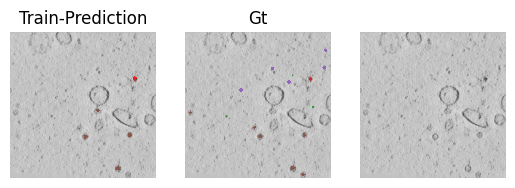

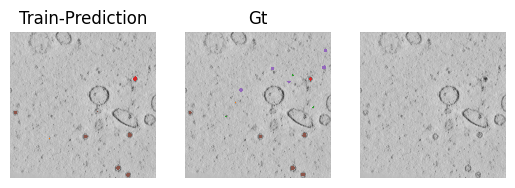

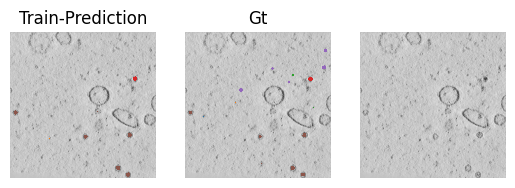

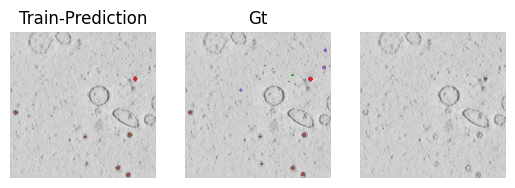

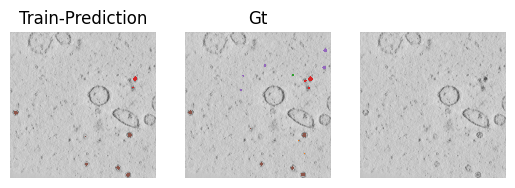

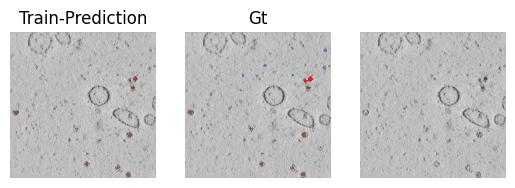

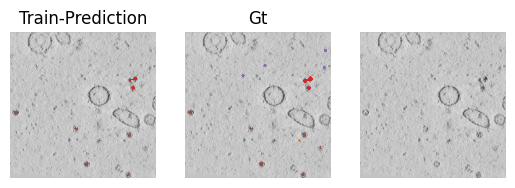

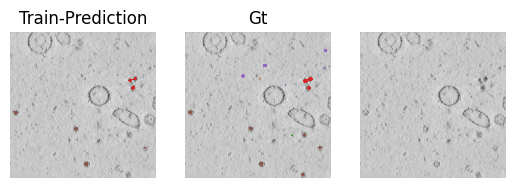

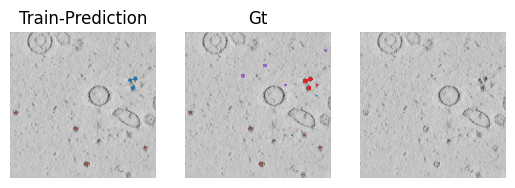

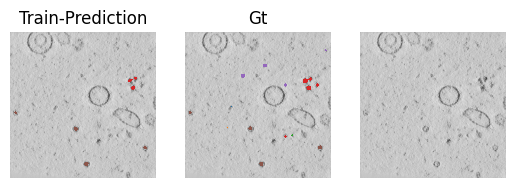

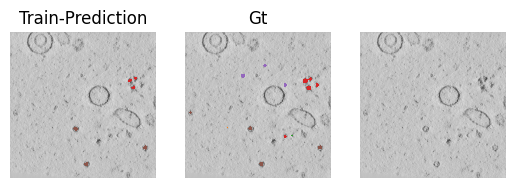

In [12]:
exp_name = CFG.valid_exp_names[-1]

pred = valid_pred_tomogram[exp_name].argmax(0)
gt = valid_gt_tomogram[exp_name]
original = valid_original_tomogram[exp_name]

for i in range(42):
    imshow_result(pred, gt, original, i)

In [13]:
exp_name = CFG.train_exp_names[-1]

pred_cls_pos = train_cls_pos[exp_name]

exp_name, np.array(pred_cls_pos).max(axis=0)

('TS_69_2', array([  6. ,   3.5, 157. , 157. ]))

In [14]:
pred_cls_pos

[[1, 3.5, 157.0, 157.0],
 [1, 0.0, 157.0, 157.0],
 [2, 3.5, 157.0, 157.0],
 [2, 0.0, 157.0, 157.0],
 [3, 3.5, 157.0, 157.0],
 [3, 0.0, 157.0, 157.0],
 [4, 3.5, 157.0, 157.0],
 [4, 0.0, 157.0, 157.0],
 [5, 3.5, 157.0, 157.0],
 [5, 0.0, 157.0, 157.0],
 [6, 3.5, 157.0, 157.0],
 [6, 0.0, 157.0, 157.0]]

In [15]:
exp_name = CFG.valid_exp_names[0]

pred_cls_pos = valid_cls_pos[exp_name]

np.array(pred_cls_pos).max(axis=0)

array([  6. ,   3.5, 157. , 157. ])

In [16]:
gt_df

index experiment        particle_type         x         y         z
0        0     TS_6_6         apo-ferritin  1916.830  3311.797   754.673
1        1     TS_6_6         apo-ferritin  1996.861  3231.277   803.577
2        2     TS_6_6         apo-ferritin  2206.512  2975.302  1179.674
3        3     TS_6_6         apo-ferritin   285.292  1379.331   417.577
4        4     TS_6_6         apo-ferritin   753.781  2633.219   973.094
..     ...        ...                  ...       ...       ...       ...
138    138     TS_6_6  virus-like-particle  2609.876  4569.876  1169.759
139    139     TS_6_6  virus-like-particle  2213.287  4135.017  1286.851
140    140     TS_6_6  virus-like-particle  3303.905  5697.825   789.744
141    141     TS_6_6  virus-like-particle  1008.748  5949.213  1077.303
142    142     TS_6_6  virus-like-particle  5749.052  3911.392   275.342

[143 rows x 6 columns]

In [17]:
score(pred_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4)

0.0

In [18]:
def create_gt_df(base_dir, exp_names):
    result_df = None
    particle_names = CFG.particles_name

    for exp_name in exp_names:
        for particle in particle_names:
            np_corrds = read_info_json(
                base_dir=base_dir, exp_name=exp_name, particle_name=particle
            )  # (n, 3)
            # 各行にexp_nameとparticle_name追加
            particle_df = pd.DataFrame(np_corrds, columns=["z", "y", "x"])
            particle_df["experiment"] = exp_name
            particle_df["particle_type"] = particle

            if result_df is None:
                result_df = particle_df
            else:
                result_df = pd.concat([result_df, particle_df], axis=0).reset_index(
                    drop=True
                )

    result_df = result_df.reset_index()
    result_df = result_df[["index", "experiment", "particle_type", "x", "y", "z"]]

    return result_df

In [19]:
# exp_name = CFG.valid_exp_names[0]
# pred = valid_pred_tomogram[exp_name].argmax(0)
# gt = valid_gt_tomogram[exp_name]
# original = valid_original_tomogram[exp_name]
import timm

encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
model.load_state_dict(torch.load("./best_model.pth"))

exp_name = CFG.train_exp_names[2]
pred = train_nshuffle_pred_tomogram[exp_name].argmax(0)
gt = train_nshuffle_gt_tomogram[exp_name]
original = train_nshuffle_original_tomogram[exp_name]

base_dir = "../../inputs/train/overlay/ExperimentRuns/"
gt_df = create_gt_df(base_dir=base_dir, exp_names=[exp_name])

import cc3d

cls_pos = []
Ascale_pos = []
res2ratio = CFG.resolution2ratio

for pred_cls in range(1, len(CFG.particles_name) + 1):
    print(pred_cls, CFG.cls2particles[pred_cls])
    cc, P = cc3d.connected_components(pred == pred_cls, return_N=True)
    stats = cc3d.statistics(cc)

    for z, y, x in stats["centroids"]:
        Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
        Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
        Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

        cls_pos.append([pred_cls, z, y, x])
        Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

pred_original_df = create_df(Ascale_pos, exp_name)

score(
    pred_original_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4
)

1 apo-ferritin
2 beta-amylase
3 beta-galactosidase
4 ribosome
5 thyroglobulin
6 virus-like-particle


0.8835655702019498

In [20]:
import timm

encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
model.load_state_dict(torch.load("./best_model.pth"))

exp_name = CFG.valid_exp_names[-1]
pred = valid_pred_tomogram[exp_name]
gt = valid_gt_tomogram[exp_name]
original = valid_original_tomogram[exp_name]

base_dir = "../../inputs/train/overlay/ExperimentRuns/"
gt_df = create_gt_df(base_dir=base_dir, exp_names=[exp_name])


for constant in np.linspace(0.2, 0.9, 20):
    initial_sikii = {
        "apo-ferritin": constant,
        "beta-amylase": constant,
        "beta-galactosidase": constant,
        "ribosome": constant,
        "thyroglobulin": constant,
        "virus-like-particle": constant,
    }

    import cc3d

    cls_pos = []
    Ascale_pos = []
    res2ratio = CFG.resolution2ratio

    for pred_cls in range(1, len(CFG.particles_name) + 1):
        sikii = initial_sikii[CFG.cls2particles[pred_cls]]
        cc, P = cc3d.connected_components(pred[pred_cls] > sikii, return_N=True)
        stats = cc3d.statistics(cc)

        for z, y, x in stats["centroids"]:
            Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
            Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
            Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

            cls_pos.append([pred_cls, z, y, x])
            Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

    pred_original_df = create_df(Ascale_pos, exp_name)

    score_ = score(
        pred_original_df,
        gt_df,
        row_id_column_name="index",
        distance_multiplier=1.0,
        beta=4,
    )

    print(sikii, score_)

0.2 0.5715944170032792
0.2368421052631579 0.5715944170032792
0.2736842105263158 0.5600447004256297
0.31052631578947365 0.5600447004256297
0.34736842105263155 0.5600447004256297
0.38421052631578945 0.5715944170032792
0.42105263157894735 0.5742806628320815
0.45789473684210524 0.562730946254432
0.49473684210526314 0.562730946254432
0.531578947368421 0.562730946254432
0.5684210526315789 0.562730946254432
0.6052631578947368 0.562730946254432
0.6421052631578947 0.562730946254432
0.6789473684210525 0.562730946254432
0.7157894736842105 0.5534439251505525
0.7526315789473683 0.5534439251505525
0.7894736842105263 0.5534439251505525
0.8263157894736841 0.5534439251505525
0.8631578947368421 0.5464024616306836
0.9 0.5464024616306836


In [21]:
import timm

encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
model.load_state_dict(torch.load("./best_model.pth"))

exp_name = CFG.valid_exp_names[0]
pred = valid_pred_tomogram[exp_name]
gt = valid_gt_tomogram[exp_name]
original = valid_original_tomogram[exp_name]

base_dir = "../../inputs/train/overlay/ExperimentRuns/"
gt_df = create_gt_df(base_dir=base_dir, exp_names=[exp_name])


for constant in np.linspace(0.2, 0.9, 20):
    initial_sikii = {
        "apo-ferritin": constant,
        "beta-amylase": constant,
        "beta-galactosidase": constant,
        "ribosome": constant,
        "thyroglobulin": constant,
        "virus-like-particle": constant,
    }

    import cc3d

    cls_pos = []
    Ascale_pos = []
    res2ratio = CFG.resolution2ratio

    for pred_cls in range(1, len(CFG.particles_name) + 1):
        sikii = initial_sikii[CFG.cls2particles[pred_cls]]
        cc, P = cc3d.connected_components(pred[pred_cls] > sikii, return_N=True)
        stats = cc3d.statistics(cc)

        for z, y, x in stats["centroids"]:
            Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
            Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
            Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

            cls_pos.append([pred_cls, z, y, x])
            Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

    pred_original_df = create_df(Ascale_pos, exp_name)

    score_ = score(
        pred_original_df,
        gt_df,
        row_id_column_name="index",
        distance_multiplier=1.0,
        beta=4,
    )

    print(sikii, score_)

0.2 0.543924504375255
0.2368421052631579 0.5455967198716231
0.2736842105263158 0.5467089105965822
0.31052631578947365 0.5458217936223818
0.34736842105263155 0.5458217936223818
0.38421052631578945 0.5458217936223818
0.42105263157894735 0.5458217936223818
0.45789473684210524 0.5458217936223818
0.49473684210526314 0.5475664570049762
0.531578947368421 0.551177694658767
0.5684210526315789 0.551177694658767
0.6052631578947368 0.5574553414903397
0.6421052631578947 0.5585047630738551
0.6789473684210525 0.5585047630738551
0.7157894736842105 0.5585047630738551
0.7526315789473683 0.559508636845586
0.7894736842105263 0.559508636845586
0.8263157894736841 0.559508636845586
0.8631578947368421 0.5634154233610682
0.9 0.5634154233610682


In [22]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
model.load_state_dict(torch.load("./best_model.pth"))

exp_name = CFG.valid_exp_names[0]
inferenced_array, n_tomogram, segmentation_map = inference(model, exp_name, train=True)
pred_original_df = inference2pos(
    pred_segmask=inferenced_array.argmax(0), exp_name=exp_name
)
gt_df = create_gt_df(
    base_dir="../../inputs/train/overlay/ExperimentRuns/", exp_names=[exp_name]
)

score(
    pred_original_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4
)

0.5475664570049762